In [10]:
import numpy as np
import matplotlib.pyplot as plt
from math import e
import scipy

plt.style.use('ggplot')

np.random.seed(42)
%matplotlib inline

In this notebook, we're going to explore a few different concepts:

1. Differential Privacy versus the Laplace Mechanism: a way to sample "intelligent" noise (e.g. error) and insert it into the results to reduce privacy loss

2. Composition: or the ability to combine differentially private responses to reason about privacy loss (or information gain, depending on how you look at it!)

3. How we can calculate a privacy budget using the above concepts! A privacy budget (or privacy accountant) allows us to limit the amount of privacy loss for an individual over the course of several queries.

To do so, we will first create an artificial dataset of ages and salaries.

In [11]:
mid_level_age = 45
mid_level_salary = 50000

age_scale = 10 #scale represents one standard deviation
salary_scale = 10000

salaries = [round(np.random.normal(mid_level_salary,salary_scale)) for _ in range(100)]
ages = [round(np.random.normal(mid_level_age,age_scale)) for _ in range(100)]

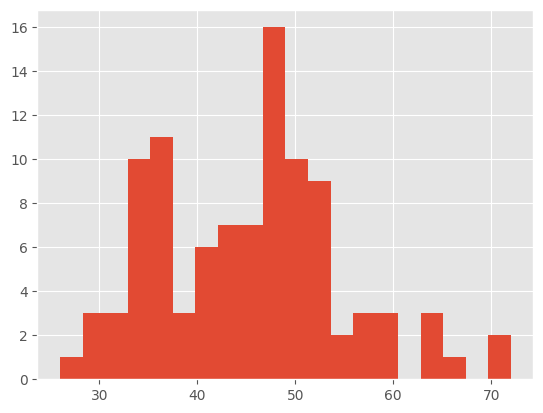

In [12]:
plt.hist(ages, bins=20);

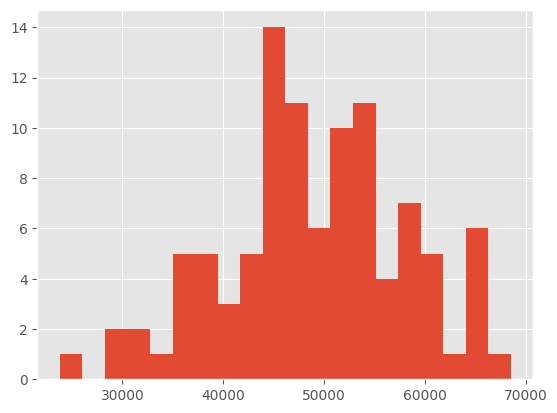

In [13]:
plt.hist(salaries, bins=20);

### Laplace Mechanism

Let's take a look at the Laplace mechanism for implementing differential privacy and notice the properties it gives us!

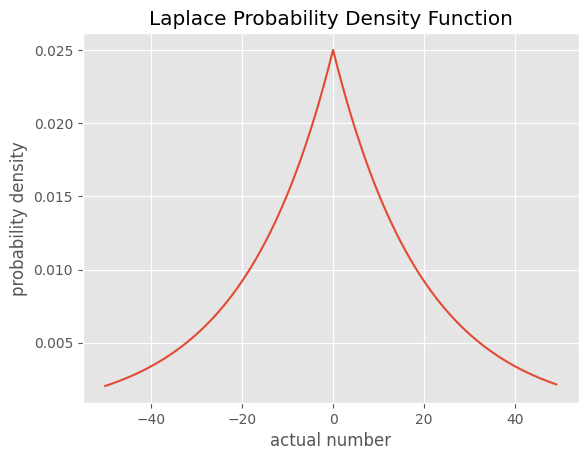

In [14]:
loc = 0
scale = 20

x = np.arange(-50., 50., 1)
pdf = np.exp(-abs(x-loc)/scale)/(2.*scale)

fig,ax= plt.subplots()
ax.plot(x, pdf);
ax.set_title('Laplace Probability Density Function')
ax.set_xlabel('actual number')
ax.set_ylabel('probability density');

Depending on the Mu and b values, we can see how the distribution changes, and how this might then affect our results.

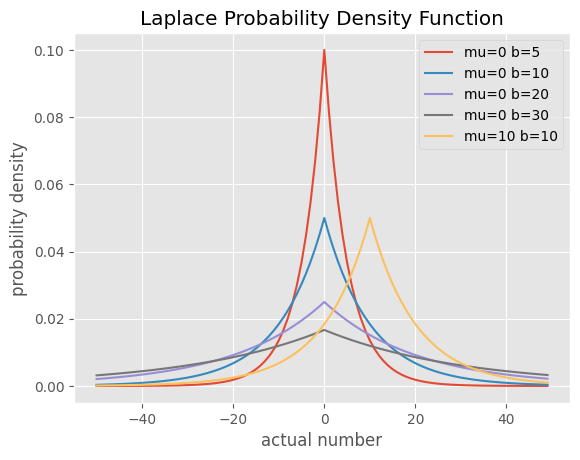

In [15]:
mu = [0, 0, 0, 0, 10]
b = [5, 10, 20, 30, 10]

x = np.arange(-50., 50., 1)
fig,ax= plt.subplots()


for mu_val, b_val in zip(mu, b):
    pdf = np.exp(-abs(x-mu_val)/b_val)/(2.*b_val)
    ax.plot(x, pdf, label='mu=%s b=%s' % (mu_val, b_val))
    
ax.set_title('Laplace Probability Density Function')
ax.set_xlabel('actual number')
ax.set_ylabel('probability density')
ax.legend()

Let's create a very naive differential privacy mechanism, that samples from Laplace and adds the noise to the result. Please note, do not use this with any real data! Instead use a well-known and audited open-source library!

NOTE: this is an incorrect usage of laplace, please do not use in a real problem! 

In [16]:
epsilon = 1.1

def naive_laplace_dp_mechanism(value, epsilon):
    # Please do not use this function, ever :)
    orig_value = value
    value =  np.random.laplace(value, 1/epsilon) # more on this choice of 1/epsilon later!
    print("Noise: {}".format(value - orig_value))
    return value

In [17]:
naive_laplace_dp_mechanism(np.mean(ages), epsilon)

Noise: 1.277692233946226


46.55769223394623

In [18]:
np.mean(ages)

45.28

And what if you added an outlier?

In [19]:
naive_laplace_dp_mechanism(np.mean(ages + [110]), epsilon)

Noise: 0.5971700616306563


46.51796214083858

In [20]:
naive_laplace_dp_mechanism(np.mean(ages + [1]), epsilon)

Noise: 0.45538840431066063


45.2969725627265

But it seems here that the mean result for the ages is unsafe. When we look at our age histogram and then at the amount of noise we are using, they appear to be mismatched! 

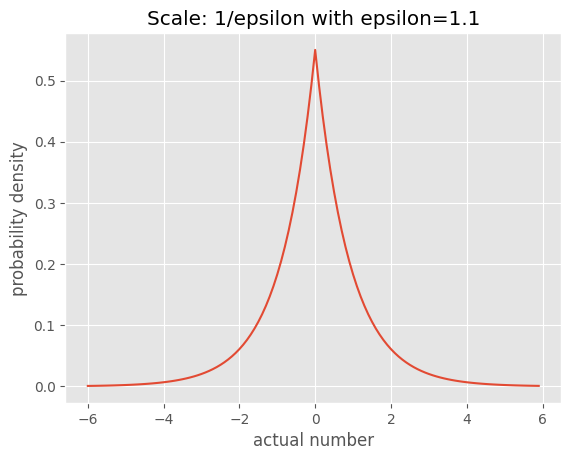

In [21]:
loc = 0
scale = 1/1.1

x = np.arange(-6., 6., .1)
pdf = np.exp(-abs(x-loc)/scale)/(2.*scale)

fig,ax= plt.subplots()
ax.plot(x, pdf, label='mu=%s b=%s' % (loc, scale))
ax.set_title('Scale: 1/epsilon with epsilon=1.1')
ax.set_xlabel('actual number')
ax.set_ylabel('probability density');

In order to figure out how to safely add noise, we need to better understand sensitivity!

### Exploring Sensitivity and Error

When we want to release data in a differentially privacy way, we need to think about the sensitivity of the result. This is how much one person can change the result of a query. 

Our error / noise insertion needs to scale with this sensitivity in order for the differential privacy guarantee to hold (i.e. that with one addition or removal to the data, I cannot get "too much" more information based on the query result).

Sensitivity is how much one person (or privacy unit) can change the results. As you can see, we've been using sensitivity improperly! Let's choose something that is easy to define. 

In [22]:
new_ages = ages + [round(np.random.normal(mid_level_age,age_scale))]

In [23]:
len(new_ages) - len(ages)

1

Now our sensitivity is correct for our counting query!

But what if we want to use bounds in order to bound a previously unbounded query. We can do so by determining those bounds and then enforcing it on our existing and incoming data. Since I know this dataset is employees who are working, I can choose bounds of 20-70 for the ages. 

In [24]:
def filter_bounds(value, lower_bound, upper_bound):
    if value < lower_bound:
        return lower_bound
    elif value > upper_bound:
        return upper_bound
    return value

bounded_ages = [filter_bounds(age, 20, 70) for age in ages]

We can now appropriately scale the noise, so that we can calculate a safe sum with sensitivity=50. But first we need to figure out how we can run multiple queries and still keep the same guarantees!

To give you a visual of the probability density of responses given our current epsilon and sensitivity, check out this graph (or feel free to change the values to fit another query you have in mind!)

### Composition

So how do we reason about how much privacy loss there is when we answer a series of questions about the data? Differential privacy promises that we can track and measure privacy loss, so how do we do this?

One amazing property of differential privacy is that the epsilon value (ε) is our privacy loss for one particular response and it has the property of being individual to each query and yet composable -- meaning if I answer two queries, I can add their epsilons to calculate the privacy loss!

What does this mean in practice? 

1. Privacy budgets! I can budget my total epsilon appropriately over the course of a certain amount of queries. This means I can detemine how much information gain / privacy loss someone has when given multiple queries across the data.

2. The privacy loss is only for the individuals contained in the query response. This means I could also count the budget per individual and stop including those individuals in the responses once their budget has been reached. Of course, this will likely than bias my data as more individuals "drop out" when their budgets are reached.

3. Depending on what epsilon I come up with, I may want to spend more of it on a particular query than others. So if I know the queries in advance or if I am releasing data all at once, I may want to allocate my budget on a query by query basis!

In [31]:
def laplace_dp_mechanism(value, epsilon, sensitivity=1):
    # Please do not use this function, ever :)
    orig_value = value
    value =  np.random.laplace(value, sensitivity/epsilon) # now you see why the 1 was a poor choice!
    print("Noise: {}".format(value - orig_value))
    return value

In [32]:
epsilon_for_sum = 0.5
epsilon_for_count = 0.5

summed_ages = laplace_dp_mechanism(np.sum(bounded_ages), epsilon_for_sum, sensitivity=50)
count_ages = laplace_dp_mechanism(len(bounded_ages), epsilon_for_count, sensitivity=1)

average_age = summed_ages / count_ages

Noise: -53.24175804583501
Noise: 1.928454653399541


In [33]:
average_age

43.88135047434459

which means a relative error of...

In [34]:
(average_age - np.mean(ages))/ np.mean(ages)

-0.030888902951753706

### Challenge

So far we've investigated the ages dataset. Try answering some basic questions about the salaries dataset using the (very simple and slightly broken) Laplace mechanism we've defined here. Some starting points might be:

- What is the average salary? 
- What is the average salary of people over 40?
- What is the average salary for people under 40?

To do so, you might first want to link the datasets. I have written some example code below to help you get started! 

_Note_: When you are first experimenting with differential privacy mechanisms and real data, you might end up using the budget just trying to figure out how you might want to release the data. This is not optimal, but it is necessary. The most essential task is to get the differential privacy mechanisms used working properly before releasing data outside of your organization or across trust boundaries.

In [ ]:
my_budget = 1.1

# Try tracking your budget as you answer the above. Think about how you spend it wisely!!! 

In [ ]:
linked_dataset = np.column_stack((ages, salaries))

In [ ]:
over_40 = linked_dataset[(linked_dataset[:,0] > 40)]

In [ ]:
num_employees_over_40 = laplace_dp_mechanism(len(over_40[:,1]), 0.3, sensitivity=1)
num_employees_over_40

In [ ]:
len(over_40[:,1])

In [ ]:
#keeping my budget honest!
my_budget -= 0.3

In [ ]:
my_budget

### Recommended Reading

- Ted on Privacy's Blog Series on Differential Privacy! https://desfontain.es/privacy/friendly-intro-to-differential-privacy.html